In [13]:
import pandas as pd
from components import component_utils, llm_utils, utils
from components.summarizer import Summarizer

my_config = utils.load_config()
my_config, my_client = llm_utils.load_llm_client(my_config, 
                                                 provider="vllm"
                                                )
data_path = "data/Worlds Best 50 Hotels.csv"
encoding = "latin-1"
# data_path = "data/muestra_datos_comex_ec.csv"
# encoding = "utf-8"

In [14]:
summ = Summarizer()
data, llm_summ, lm = summ.summarize(data_path, 
                                my_config, 
                                my_client, 
                                encoding=encoding,
                                summary_method="llm"
                               )

In [15]:
from components.persona import PersonaExplorer

per = PersonaExplorer()
llm_personas = per.generate(llm_summ,
                            my_config,
                            my_client,
                            n=3
                           )

In [16]:
llm_personas

{'personas': [{'persona': 'Gerente de Hotel/Director de Operaciones',
   'rationale': 'Este rol es crucial porque el dataset contiene detalles sobre habitaciones, tarifas, áreas de comida y bebida, y servicios. Un gerente de hotel podría usar este data para analizar la competitividad de su hotel en relación con los mejores del mundo, optimizar precios, identificar áreas de mejora en las ofertas de servicios y analizar la rentabilidad en función del número de habitaciones y la ubicación.'},
  {'persona': 'Agencia de Viajes / Consultor de Turismo',
   'rationale': 'Las agencias de viajes y consultores de turismo utilizan datos sobre hoteles para recomendar opciones a sus clientes. Este dataset proporciona información detallada sobre los 50 mejores hoteles, incluyendo ubicación, servicios y tarifas, permitiéndoles ofrecer recomendaciones personalizadas y asesoramiento experto a los viajeros. El ranking es un factor clave en sus recomendaciones.'},
  {'persona': 'Analista de Tendencias del

In [17]:
llm_personas['personas'][2]['persona']

'Analista de Tendencias del Sector Hotelero'

In [26]:
[per['persona'] for per in llm_personas['personas']]

['Gerente de Hotel/Director de Operaciones',
 'Agencia de Viajes / Consultor de Turismo',
 'Analista de Tendencias del Sector Hotelero']

In [18]:
from components.goal import GoalExplorer

goal = GoalExplorer()
llm_goals = goal.generate(llm_summ,
                          my_config,
                          my_client,
                          persona=llm_personas['personas'][2]['persona'],
                          n=3
                         )

In [19]:
llm_goals

{'goals': [{'index': 0,
   'question': '¿Existe una correlación entre el ranking del hotel y su tarifa inicial?',
   'visualization': "Diagrama de dispersión de 'Rank' contra 'Starting_Rate_in____'.",
   'rationale': "Este gráfico nos permitirá visualizar si los hoteles mejor clasificados ('Rank') tienden a tener tarifas iniciales más altas ('Starting_Rate_in____').  Analizar la correlación entre estas dos variables nos ayudará a comprender la relación entre la percepción de calidad (ranking) y el precio que cobra el hotel, lo cual es crucial para entender estrategias de precios en el sector hotelero."},
  {'index': 1,
   'question': '¿Cómo se distribuyen el número de habitaciones entre los hoteles del ranking?',
   'visualization': "Histograma de 'Total_Rooms'.",
   'rationale': "Este histograma nos proporciona una visión general de la distribución del número de habitaciones ('Total_Rooms') entre los 50 mejores hoteles. Esto nos permite identificar si la mayoría de los hoteles en la l

In [20]:
from components.viz_generator import VizGenerator

vizgen = VizGenerator()
goals_with_code, mes =  vizgen.generate(llm_summ,
                                   llm_goals,
                                   my_config,
                                   my_client, 
                                   library="seaborn"
                                  )

scafold_ques ¿Existe una correlación entre el ranking del hotel y su tarifa inicial?
scafold_vis Diagrama de dispersión de 'Rank' contra 'Starting_Rate_in____'.
scafold_lib seaborn
#####goal_que ¿Existe una correlación entre el ranking del hotel y su tarifa inicial?
#####goal_vis Diagrama de dispersión de 'Rank' contra 'Starting_Rate_in____'.
#####viz_lib seaborn
scafold_ques ¿Cómo se distribuyen el número de habitaciones entre los hoteles del ranking?
scafold_vis Histograma de 'Total_Rooms'.
scafold_lib seaborn
#####goal_que ¿Cómo se distribuyen el número de habitaciones entre los hoteles del ranking?
#####goal_vis Histograma de 'Total_Rooms'.
#####viz_lib seaborn
scafold_ques ¿Qué ubicaciones geográficas ('Location') tienen los hoteles mejor valorados?
scafold_vis Gráfico de barras mostrando el recuento de hoteles por 'Location'.
scafold_lib seaborn
#####goal_que ¿Qué ubicaciones geográficas ('Location') tienen los hoteles mejor valorados?
#####goal_vis Gráfico de barras mostrando el

In [21]:
#llm_enriched_df = utils.summarize_properties_to_df(llm_summ["fields"])
#llm_enriched_df.to_excel("enriched_muestra_comex.xlsx", index=False)

In [22]:
# import re

# goals_with_code['goals'][2]['code'] = goals_with_code['goals'][2]['code'].replace("barplot", "brplot")

In [33]:
goals_with_code['goals'][0]['question']

'¿Existe una correlación entre el ranking del hotel y su tarifa inicial?'

In [23]:
from components.executor import ChartExecutor

chart_ex = ChartExecutor()

charts = chart_ex.execute(
    data,
    llm_summ,
    in_goals_with_code=goals_with_code,
    library="seaborn"
    )

<string>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



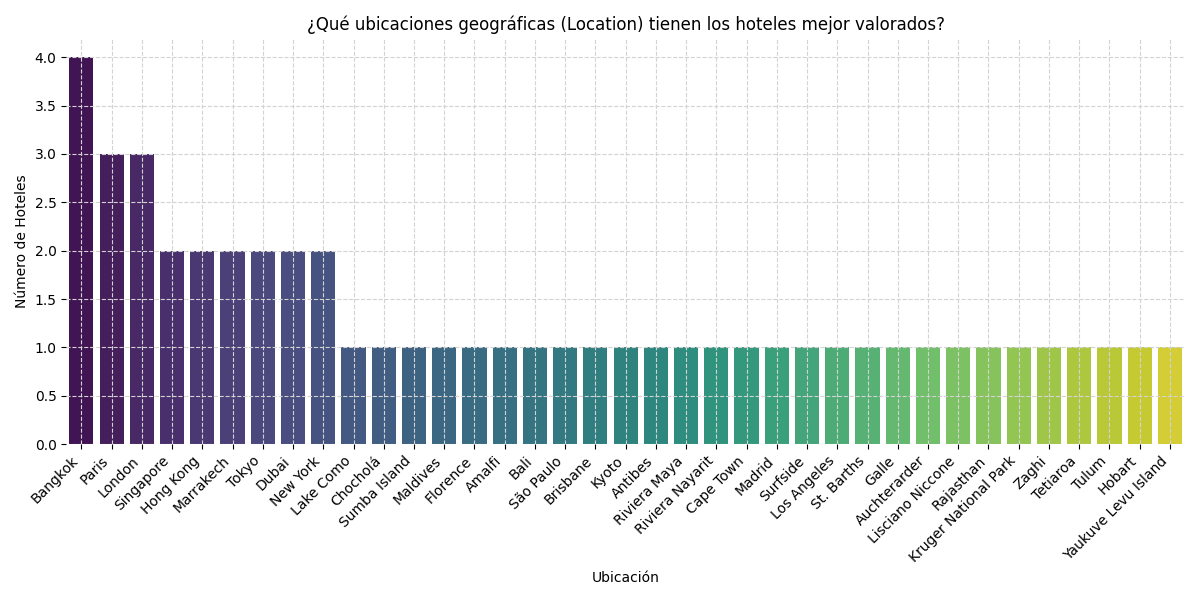

In [29]:
charts[2]

In [13]:
# Solo si hubieron graficos que no se ejecutaron
from components.viz_repairer import VizRepairer

bad_charts = [chart for chart in charts if not chart.status]
if bad_charts:
    goals_with_bad_code = {
        "goals": []
    }
    
    for bad_chart in bad_charts:
        goals_with_bad_code["goals"].append(
            {
                "index": bad_chart.index,
                "question": bad_chart.goal_question,
                "visualization": bad_chart.goal_visualization,
                "rationale": bad_chart.goal_rationale,
                "code": bad_chart.code,
                "error_message": bad_chart.error["message"]
            }
        )
    
    vizrep = VizRepairer()
    goals_with_repaired_code =  vizrep.generate(llm_summ,
                                                goals_with_bad_code,
                                                my_config,
                                                my_client, 
                                                library="seaborn"
                                               )
    
    repaired_charts = chart_ex.execute(data,
                                       llm_summ,
                                       in_goals_with_code=goals_with_repaired_code,
                                       library="seaborn"
                                      )

    repaired_charts[0]

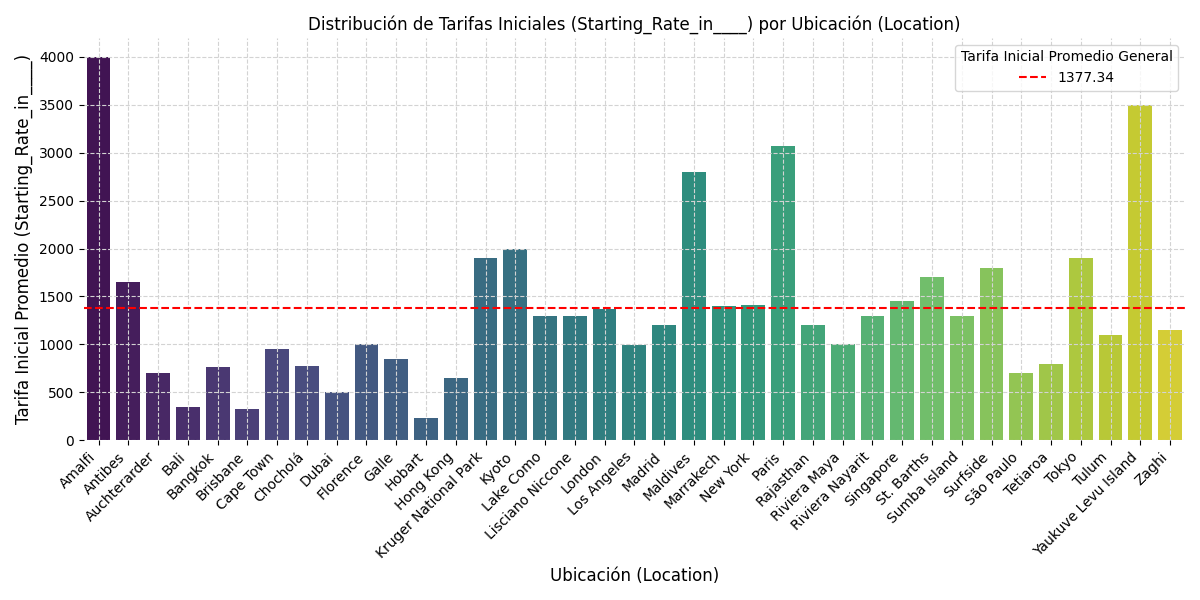

In [14]:
###### EDICION
chart_to_edit = charts[2]
chart_to_edit

In [15]:
from components.viz_editor import VizEditor

instruction = "Utiliza colores pasteles y pon los textos del eje x en vertical"

vized = VizEditor()
edited_code = vized.generate(chart_to_edit.code,
                             llm_summ,
                             instruction,
                             my_config,
                             my_client, 
                             library="seaborn"
                            )

goal_with_edited_code = {
    "goals": []
}

goal_with_edited_code["goals"].append(
    {
        "index": chart_to_edit.index,
        "question": chart_to_edit.goal_question,
        "visualization": chart_to_edit.goal_visualization,
        "rationale": chart_to_edit.goal_rationale,
        "code": edited_code,
        #"error_message": chart_to_edit.error["message"]
    }
)

In [16]:
edited_chart = chart_ex.execute(data,
                                llm_summ,
                                in_goals_with_code=goal_with_edited_code,
                                library="seaborn"
                               )

<string>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



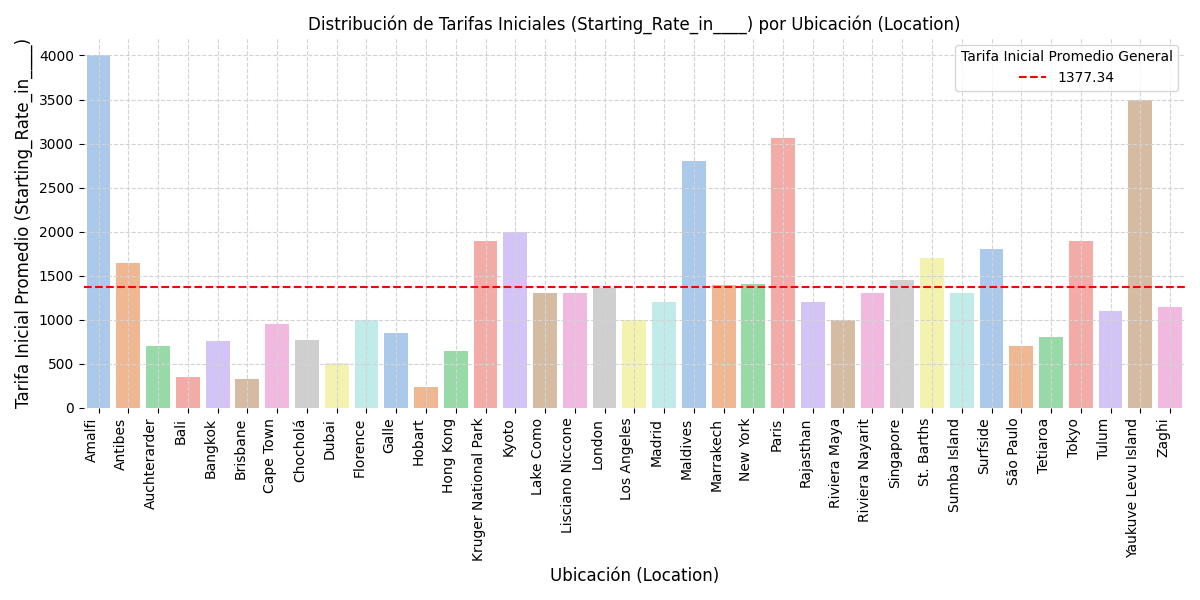

In [17]:
edited_chart[0]

In [18]:
# Solo si hubieron graficos que no se ejecutaron cuando se editaron

if not edited_chart[0].status:
    goal_with_bad_edited_code = {
        "goals": []
    }

    goal_with_bad_edited_code["goals"].append(
        {
            "index": edited_chart.index,
            "question": edited_chart.goal_question,
            "visualization": edited_chart.goal_visualization,
            "rationale": edited_chart.goal_rationale,
            "code": edited_chart.code,
            "error_message": edited_chart.error["message"]
        }
    )

    goal_with_repaired_code =  vizrep.generate(llm_summ,
                                               goal_with_bad_edited_code,
                                               my_config,
                                               my_client, 
                                               library="seaborn"
                                               )

    repaired_edited_chart = chart_ex.execute(data,
                                             llm_summ,
                                             in_goals_with_code=goal_with_repaired_code,
                                             library="seaborn"
                                            )

In [30]:
#### Creación de un nuevo gráfico a partir de un prompt cualquiera
prompt = "Muestrame un grafico de barras con los tres(3) hoteles con más habitaciones"
prompt2 = "Muestrame cuantas habitaciones tienen solamente hoteles de estas ubicaciones: new york, los angeles"

my_goal = goal.generate_from_user_prompt(prompt2)

In [31]:
my_goal_with_code, messa =  vizgen.generate(llm_summ,
                                     my_goal,
                                     my_config,
                                     my_client, 
                                     library="seaborn"
                                    )

scafold_ques Muestrame cuantas habitaciones tienen solamente hoteles de estas ubicaciones: new york, los angeles
scafold_vis 'Useful visualization selecting correct columns provided in summary'
scafold_lib seaborn
#####goal_que Muestrame cuantas habitaciones tienen solamente hoteles de estas ubicaciones: new york, los angeles
#####goal_vis 'Useful visualization selecting correct columns provided in summary'
#####viz_lib seaborn


In [32]:
my_goal_chart = chart_ex.execute(data,
                                 llm_summ,
                                 in_goals_with_code=my_goal_with_code,
                                 library="seaborn"
                                )

<string>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



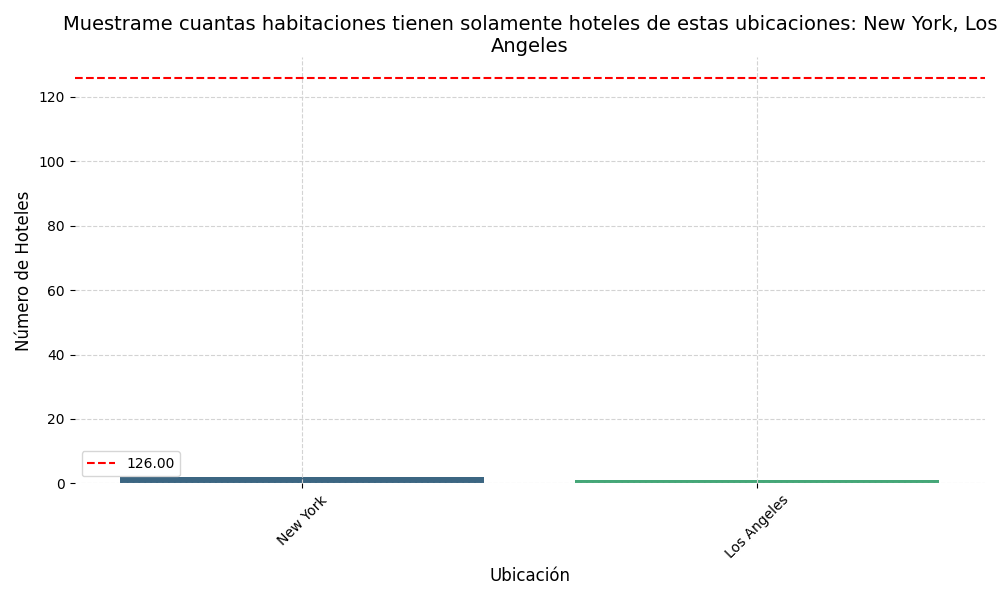

In [33]:
my_goal_chart[0]

In [23]:
# Solo si el graficos no se ejecutó
if not my_goal_chart[0].status:
    my_goal_with_bad_code = {
        "goals": []
    }

    my_goal_with_bad_code["goals"].append(
        {
            "index": my_goal_chart.index,
            "question": my_goal_chart.goal_question,
            "visualization": my_goal_chart.goal_visualization,
            "rationale": my_goal_chart.goal_rationale,
            "code": my_goal_chart.code,
            "error_message": my_goal_chart.error["message"]
        }
    )

    my_goal_with_repaired_code = vizrep.generate(llm_summ,
                                                 my_goal_with_bad_code,
                                                 my_config,
                                                 my_client, 
                                                 library="seaborn"
                                                )

    my_repaired_chart = chart_ex.execute(data,
                                         llm_summ,
                                         goals_with_code=my_goal_with_repaired_code,
                                         library="seaborn"
                                        )